# Machine Learning Project: ASL Image Recognition

This project aims to develop an image recognition system for the American Sign Language (ASL) alphabet using machine learning techniques. The main goal is to create an accurate and robust model capable of effectively classifying ASL letters.

Dataset: https://www.kaggle.com/datasets/ayuraj/asl-dataset

One issue with this dataset is the limited amount of available data, which is not sufficient to apply more complex machine learning methods. For this reason, data augmentation techniques are used, and transformations have been applied to the original images.
The following models are implemented with the goal of correctly recognizing both original and modified images.
- Data exploration
- Preprocessing: class removal, normalization, and standardization
- Supervised Learning: K-Nearest Neighbors, Naive Bayes, Random Forest

- Neural networks

- Data augmentation

- Testing modified images on models trained with original data

- Convolutional neural networks


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
import glob
import os
import zipfile
from google.colab import files
from PIL import Image
import cv2
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Upload the file kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elisacoceani","key":"e5340415a9d0e5bc330605a8853db982"}'}

In [69]:
!rm -r {'asl_dataset/asl_dataset'}

In [68]:
# Crea la directory .kaggle e sposta il file kaggle.json in essa
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Imposta i permessi per il file kaggle.json
os.chmod("/root/.kaggle/kaggle.json", 600)

# Scarica il dataset da Kaggle
!kaggle datasets download -d ayuraj/asl-dataset

# Estrai il dataset
with zipfile.ZipFile("asl-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall('.')



Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
asl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


### Data exploration e preprocessing


In [ ]:
# Dataset Categories
dataset_dir= 'asl_dataset'
categories = os.listdir(dataset_dir)
categories.sort()
print(f"Number of categories: {len(categories)}")
print(f"Categories: {categories}")

Numero di categorie: 24
Categorie: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [ ]:
# Images dimension
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

#  Number of images in every subfolder
def count_images_in_folder(folder_path):
    return len(glob.glob(os.path.join(folder_path, '*.jpeg')))

In [ ]:
# Delete numbers and the letters j and z

# Classes to delete
remove_classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','j','z']

for class_name in remove_classes:
    class_dir = os.path.join(dataset_dir, class_name)
    # Check if the directory exists
    if os.path.exists(class_dir) and os.path.isdir(class_dir):
        shutil.rmtree(class_dir)  # Remore directory and its contents


categories = os.listdir(dataset_dir)
categories.sort()
print(f"Number of Categories: {len(categories)}")
print(f"Categories: {categories}")

Numero di categorie: 24
Categorie: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


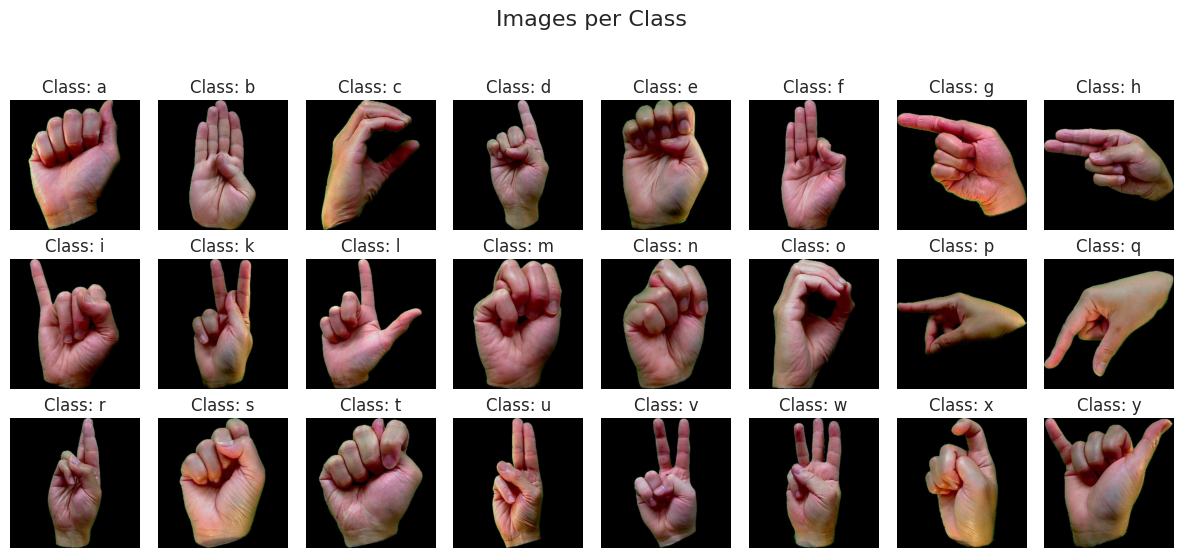

In [ ]:
# Dataset visualization

# Name of the classes
classes = sorted(os.listdir(dataset_dir))

plt.figure(figsize=(12,6))
num_classes = len(classes)
num_cols = (num_classes + 2) // 3

for i, class_name in enumerate(classes):

    class_dir = os.path.join(dataset_dir, class_name)

    # First image of every folder
    image_path = os.path.join(class_dir, os.listdir(class_dir)[0])

    # Upload the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot imahe
    plt.subplot(3, num_cols, i + 1)
    plt.imshow(img_rgb)
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.suptitle('Images per Class', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [ ]:
# Dataset dimension
first_class_dir = next(filter(lambda x: count_images_in_folder(os.path.join(dataset_dir, x)) > 0, categories), None)
first_image_path = glob.glob(os.path.join(dataset_dir, first_class_dir, '*.jpeg'))[0] if first_class_dir else None
image_dimensions = get_image_size(first_image_path) if first_image_path else None

print(f"Image's dimension: {image_dimensions}")

class_image_counts = {class_name: count_images_in_folder(os.path.join(dataset_dir, class_name)) for class_name in categories}
total_images = sum(map(lambda x: count_images_in_folder(os.path.join(dataset_dir, x)), categories))
# Total of images
print(f"Total of images: {total_images}")

# Images per folder
for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}': {count} immages")

Dimensione dell'immagine: (400, 400)
Numero totale di immagini nel dataset: 1675
Classe 'a': 70 immagini
Classe 'b': 70 immagini
Classe 'c': 70 immagini
Classe 'd': 70 immagini
Classe 'e': 70 immagini
Classe 'f': 70 immagini
Classe 'g': 70 immagini
Classe 'h': 70 immagini
Classe 'i': 70 immagini
Classe 'k': 70 immagini
Classe 'l': 70 immagini
Classe 'm': 70 immagini
Classe 'n': 70 immagini
Classe 'o': 70 immagini
Classe 'p': 70 immagini
Classe 'q': 70 immagini
Classe 'r': 70 immagini
Classe 's': 70 immagini
Classe 't': 65 immagini
Classe 'u': 70 immagini
Classe 'v': 70 immagini
Classe 'w': 70 immagini
Classe 'x': 70 immagini
Classe 'y': 70 immagini


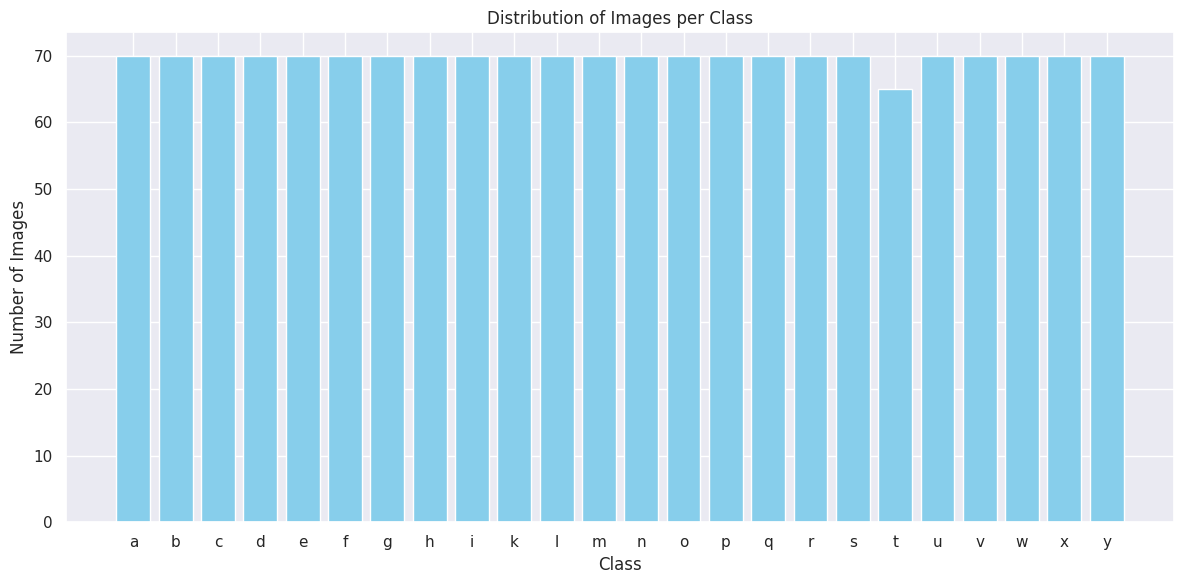

In [ ]:
# Images distribution
class_names = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks()
plt.tight_layout()

plt.show()

Image Resizing

In [ ]:
"""
Function to process the images:
Each image in the dataset is resized to a 'target_size', converted to grayscale, and normalized.
A dictionary, label_mapping, is created to assign a numeric label to each class.

"""
def process_images(dataset_dir,target_size):
    images = []
    labels = []
    mapping = {}
    label_mapping = {}

    # Iterates through the subdirectories in the dataset directory.
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)

        if os.path.isdir(class_path):
            # Map the class to a numeric index
            if class_dir not in mapping:
                mapping[class_dir] = len(mapping)
                label_mapping[len(label_mapping)] = class_dir

            # Iterate through the images in the class subdirectory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                if img is not None:
                    # Resize the image to the target size and normalize the pixels
                    img_resized = cv2.resize(img_gray, target_size)
                    img_normalized = img_resized.flatten().astype(float) / 255.0
                    images.append(img_normalized)
                    labels.append(mapping[class_dir])

    X = np.array(images)
    y = np.array(labels)

    return X, y, label_mapping

In [ ]:
# Image resizing and class mapping
target_size = (128, 128)
X, y, label_mapping = process_images(dataset_dir, target_size)
print(label_mapping)


{0: 'i', 1: 'w', 2: 'o', 3: 'l', 4: 'g', 5: 's', 6: 'q', 7: 'v', 8: 'b', 9: 'h', 10: 'c', 11: 'y', 12: 'x', 13: 'p', 14: 'e', 15: 'a', 16: 'f', 17: 'r', 18: 't', 19: 'u', 20: 'k', 21: 'n', 22: 'm', 23: 'd'}


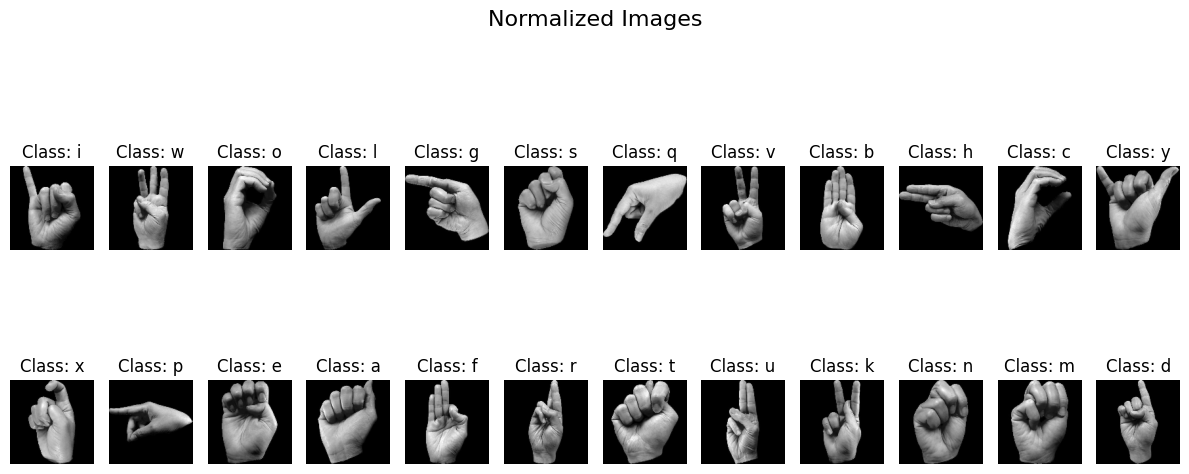

In [ ]:
# Normalizing images

unique_classes = np.unique(y)

plt.figure(figsize=(12, 6))

for i, class_idx in enumerate(unique_classes):

    idx = np.where(y == class_idx)[0][0]
    image = X[idx].reshape(target_size)  # Reshape images to original size

    # Get the original class name using label_mapping
    class_name = label_mapping[class_idx]

    # Plot 
    plt.subplot(2, len(unique_classes)//2, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.suptitle('Normalized Images', fontsize=16)
plt.tight_layout()
plt.show()


Standardization

In [ ]:

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)




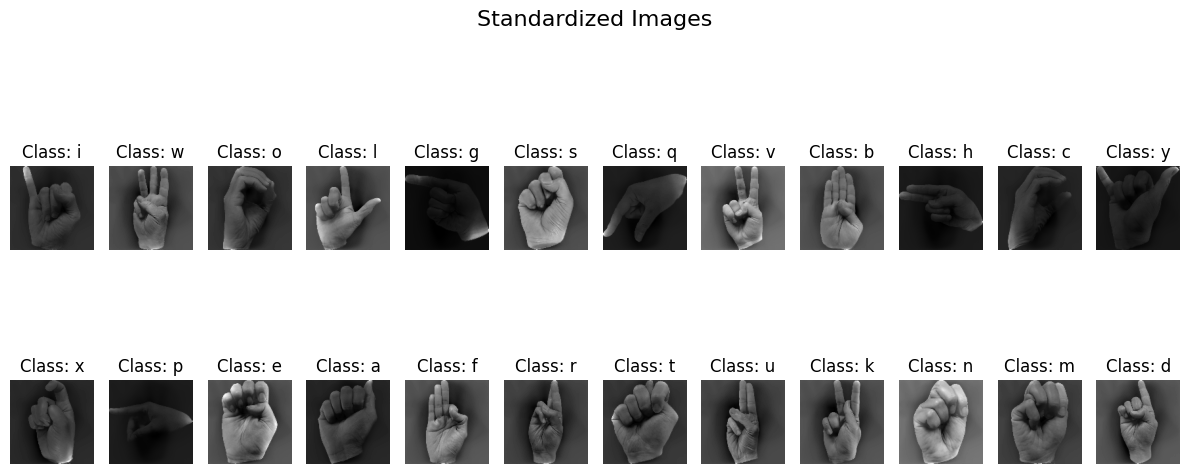

In [ ]:
# Visualization of standardized images
plt.figure(figsize=(12, 6))

for i, class_idx in enumerate(unique_classes):

    idx = np.where(y == class_idx)[0][0]
    image = X_standardized[idx].reshape(target_size)  # Reshape 

   
    class_name = label_mapping[class_idx]

    # Plot 
    plt.subplot(2, len(unique_classes)//2, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.suptitle('Standardized Images', fontsize=16)
plt.tight_layout()
plt.show()


### Supervised learning

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X_standardized, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

# Dimensions of datasets
print(f"DImensions of datasets:")
print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation set: X_val {X_val.shape}, y_val {y_val.shape}")
print(f"Test set: X_test {X_test.shape}, y_test {y_test.shape}")

Dimensioni dei set di dati:
Training set: X_train (1172, 16384), y_train (1172,)
Validation set: X_val (252, 16384), y_val (252,)
Test set: X_test (251, 16384), y_test (251,)


#### Low dimensional data visualization

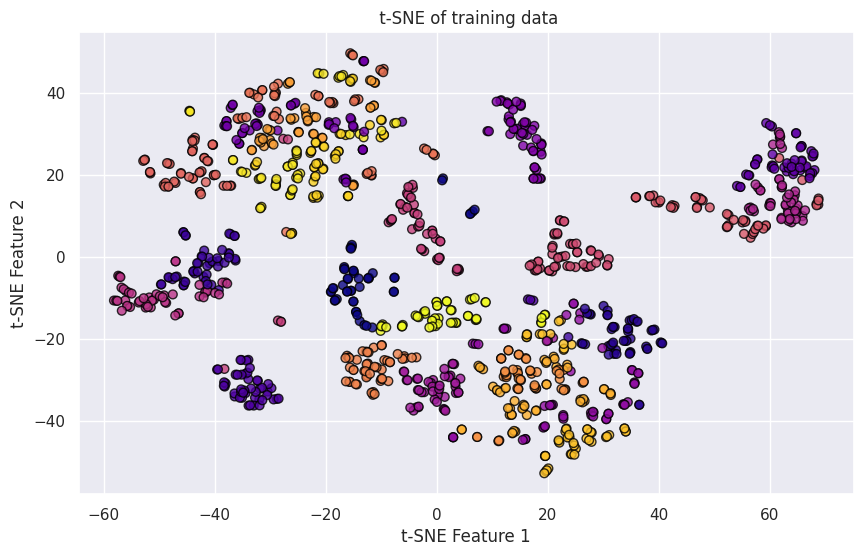

In [ ]:
# Visualization with t-SNe
from sklearn.manifold import TSNE
tsne = TSNE(2, random_state=1, n_iter=1500, n_jobs=5)
res = tsne.fit_transform(X_train)
sns.set(rc={'figure.figsize':(9,6)})
plt.figure(figsize = (10,6))

# Plot the first scatterplot in the first subplot
plt.scatter(x=res[:,0], y=res[:,1],c= y_train,cmap='plasma', s=40, alpha=0.8, edgecolors='black')

plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.title(" t-SNE of training data")
plt.show()

#### K-Nearest Neighbors

k = 1, Cross-validation Mean Accuracy: 0.9744, Test Accuracy: 0.9841
k = 3, Cross-validation Mean Accuracy: 0.9514, Test Accuracy: 0.9721
k = 5, Cross-validation Mean Accuracy: 0.9122, Test Accuracy: 0.9283
k = 7, Cross-validation Mean Accuracy: 0.8772, Test Accuracy: 0.9004
k = 11, Cross-validation Mean Accuracy: 0.8678, Test Accuracy: 0.8725
k = 15, Cross-validation Mean Accuracy: 0.8541, Test Accuracy: 0.8645


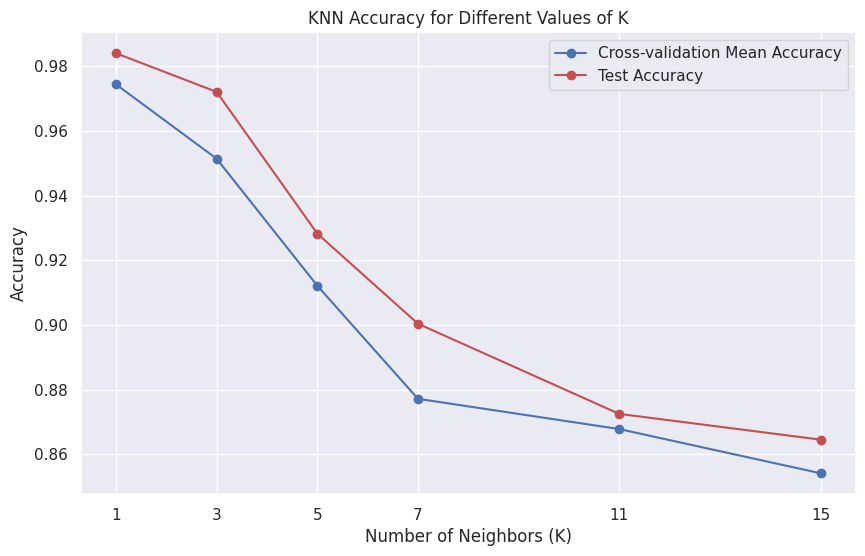

In [ ]:
# Implementation of the KNN model
from sklearn.neighbors import KNeighborsClassifier

k_values = [1,3,5,7,11,15]

# Initialize lists to store results
cv_mean_scores = []
test_scores = []

# Iterate over each k value
for k in k_values:
    # Initialize KNN classifier with current k
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform cross-validation METTERE K FOLD

    cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
    cv_mean_scores.append(np.mean(cv_scores))

    # Fit the model on the training data
    knn.fit(X_train, y_train)

    # Evaluate the model on the test data
    test_accuracy = knn.score(X_test, y_test)
    test_scores.append(test_accuracy)

    # Print results for the current k
    print(f"k = {k}, Cross-validation Mean Accuracy: {np.mean(cv_scores):.4f}, Test Accuracy: {test_accuracy:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_mean_scores, marker='o', linestyle='-', color='b', label='Cross-validation Mean Accuracy')
plt.plot(k_values, test_scores, marker='o', linestyle='-', color='r', label='Test Accuracy')
plt.title('KNN Accuracy for Different Values of K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()



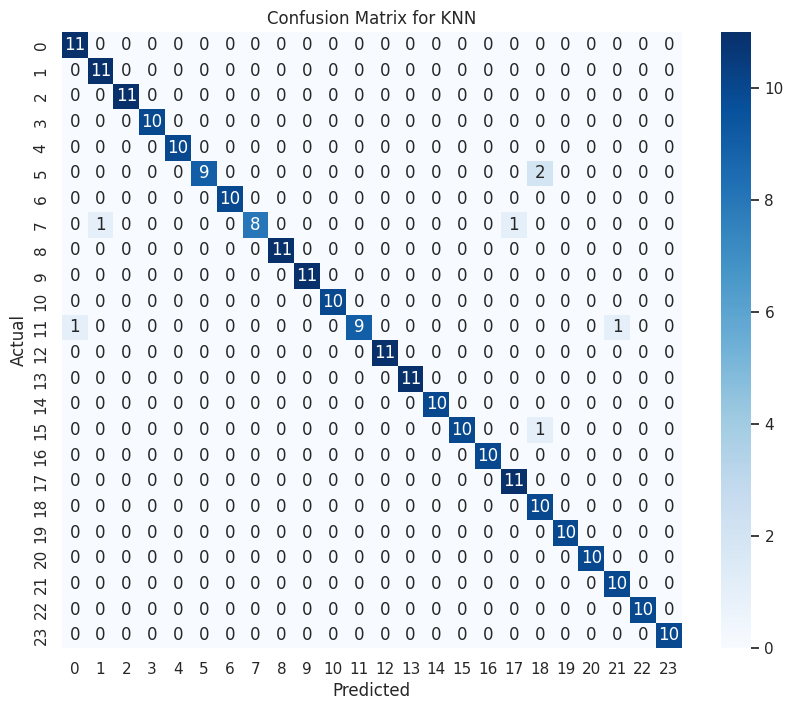

In [25]:

best_k = 3
knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform')

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predictions on the test data
y_pred = knn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN')
plt.show()

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Accuracy of the model
accuracy_gnb = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_gnb:.2f}')



Accuracy: 0.68


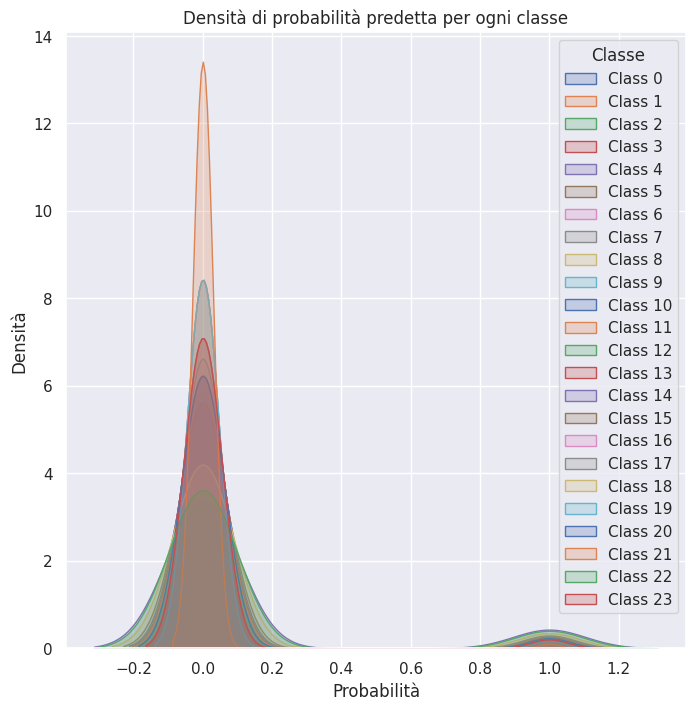

In [ ]:
# Function to display the predicted probability density for each class
def visualize_class_probabilities(gnb, X_test, y_test):
    # Calculate the predicted probabilities for each class for each sample
    y_prob = gnb.predict_proba(X_test)

    # Plot
    num_classes = len(np.unique(y))
    plt.figure(figsize=(8,8))

    # For each class, plot the KDE of the predicted probability density
    for i in range(num_classes):
        class_probabilities = y_prob[:, i]
        sns.kdeplot(class_probabilities, label=f'Class {i}', fill=True)

    plt.title('Predicted probability density for each class')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend(title='Class')
    plt.show()



visualize_class_probabilities(gnb, X_test, y_test)

In [28]:

# Predictions on the test data

y_test_names = np.array([label_mapping[yi] for yi in y_test])
y_pred_names = np.array([label_mapping[yi] for yi in y_pred])

# Classification report
cr = classification_report(y_test_names, y_pred_names)

print("Classification Report:")
print(cr)


Classification Report:
              precision    recall  f1-score   support

           a       1.00      0.64      0.78        11
           b       0.86      0.55      0.67        11
           c       1.00      0.90      0.95        10
           d       0.86      0.60      0.71        10
           e       0.32      0.90      0.47        10
           f       0.80      0.40      0.53        10
           g       1.00      1.00      1.00        10
           h       1.00      1.00      1.00        11
           i       0.92      1.00      0.96        11
           k       0.67      0.60      0.63        10
           l       1.00      0.90      0.95        10
           m       0.28      0.70      0.40        10
           n       0.50      0.10      0.17        10
           o       0.80      0.73      0.76        11
           p       1.00      1.00      1.00        11
           q       1.00      0.90      0.95        10
           r       0.75      0.55      0.63        11
    

#### Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Defining the n_estimators values ​​to test
n_estimators_values = [10,20,30,50]

# Initializing variables to keep track of the best model
best_accuracy = 0
best_n_estimators = None
best_model = None

# Loop over each value of n_estimators
for n_estimators in n_estimators_values:
    print(f"Training with n_estimators = {n_estimators}")

    # RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Training
    rf_classifier.fit(X_train, y_train)

    # Validation
    y_val_pred = rf_classifier.predict(X_val)

    # Accuracy
    accuracy_val = accuracy_score(y_val, y_val_pred)
    print(f'Accuracy on validation set: {accuracy_val:.4f}')
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_n_estimators = n_estimators
        best_model = rf_classifier
    print()

# Report of the best model
print(f"Best model found with n_estimators = {best_n_estimators}")
print(f"Accuracy on validation set: {best_accuracy:.4f}")

#Final evaluation of the best model on the test set
y_test_pred = best_model.predict(X_test)

# Accuracy on test set
accuracy_test_randomf = accuracy_score(y_test, y_test_pred)
print(f'\nAccuracy on test set: {accuracy_test_randomf:.4f}')

# Detailed classification report on the test set
print('\nClassification Report on test set:')
print(classification_report(y_test, y_test_pred))

Training with n_estimators = 10
Accuracy on validation set: 0.9643

Training with n_estimators = 20
Accuracy on validation set: 0.9603

Training with n_estimators = 30
Accuracy on validation set: 0.9683

Training with n_estimators = 50
Accuracy on validation set: 0.9722

Best model found with n_estimators = 50
Accuracy on validation set: 0.9722

Accuracy on test set: 0.9602

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      1.00      1.00        11
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        10
           4       0.91      1.00      0.95        10
           5       0.91      0.91      0.91        11
           6       1.00      1.00      1.00        10
           7       1.00      0.90      0.95        10
           8       0.91      0.91      0.91        11
           9       1.00      1.00      1.00   

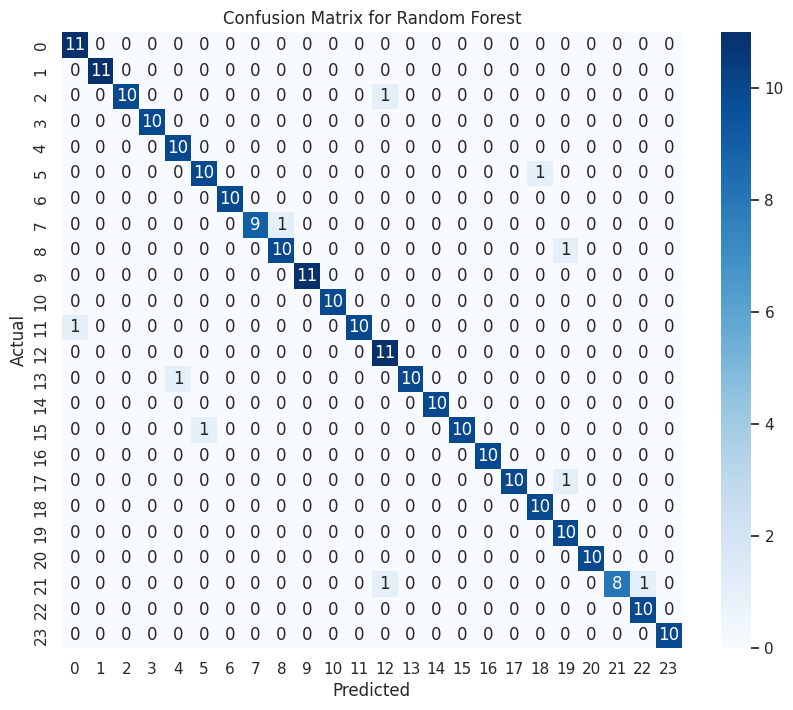

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

### Neural networks

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Datasets dimensions
print(f"Dimensioni dei set di dati:")
print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set: X_test {X_test.shape}, y_test {y_test.shape}")

Dimensioni dei set di dati:
Training set: X_train (1340, 16384), y_train (1340,)
Test set: X_test (335, 16384), y_test (335,)


In [32]:
batch_size = 16

In [ ]:
# Create the dataset and transform X and y into tensors
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).reshape(image_height,image_width,num_channels)),
    transforms.ToTensor(),
    transforms.Lambda( lambda x: x.float())
])


In [ ]:
image_height = 128
image_width = 128
num_channels = 1

# Create training dataset
train_dataset = Dataset(X_train, y_train, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testset
test_dataset = Dataset(X_test, y_test, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Get the accuracy of one batch
def batch_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()

In [36]:
def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accuracy = []

    norms = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_loss += loss.item()
            train_acc += batch_accuracy(logits, labels)


        losses.append(train_loss / i)
        accuracy.append(train_acc/i)
        norms.append(compute_weight_norm(model))

        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_loss / i:.3f} | Train Accuracy: {train_acc/i:.3f} | Time: {time()-start:.2f}")

    return losses, accuracy, norms

In [37]:
# Three Layer fully connected

class ThreeLayerModel(nn.Module):

  def __init__(self):
    super(ThreeLayerModel, self).__init__()

    self.l1 = nn.Linear(128*128,256)
    self.l2 = nn.Linear(256,128)
    self.l3 = nn.Linear(128,24)

  def forward(self,x):
    x = x.flatten(start_dim=1)
    x = self.l1(x)
    x= F.relu(x)
    x = self.l2(x)
    x = F.relu(x)
    x = self.l3(x)

    return x

In [38]:
threelayermodel = ThreeLayerModel()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(threelayermodel.parameters(), lr=0.001)

loss3, accuracy3, norms = train_model(threelayermodel, 5, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.422 | Train Accuracy: 59.036 | Time: 4.29
Epoch: 2 | Loss: 0.328 | Train Accuracy: 90.236 | Time: 3.29
Epoch: 3 | Loss: 0.132 | Train Accuracy: 97.113 | Time: 3.24
Epoch: 4 | Loss: 0.111 | Train Accuracy: 97.967 | Time: 3.70
Epoch: 5 | Loss: 0.062 | Train Accuracy: 99.197 | Time: 3.65


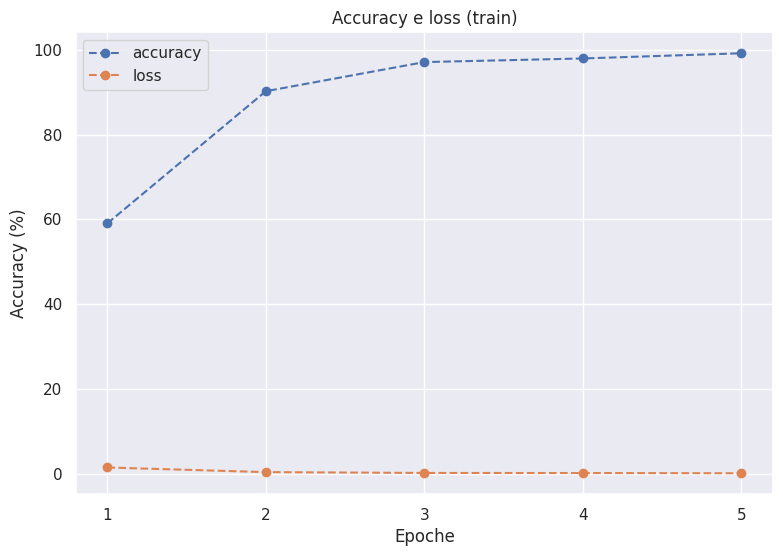

In [ ]:
# Plot of Train Loss and accuracy

epochs =  [1,2,3,4,5]

fig, ax=plt.subplots()
ax.plot(epochs, accuracy3, label = "accuracy",marker='o', linestyle='--')
ax.plot(epochs, loss3, label = "loss",marker='o', linestyle='--')

plt.xlabel('Epoche')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy e loss (train)')
plt.xticks(epochs)
plt.grid(True)
ax.legend()

In [40]:
class ConvModel(nn.Module):
  def __init__(self):
    super(ConvModel,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels= 2, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=2, out_channels=4,kernel_size=3)
    self.l1 = nn.Linear(4*124*124,512)
    self.l2 = nn.Linear(512,24)

  def forward(self, x):

    # Convolution + ReLU + Pooling
    x = F.relu(self.conv1(x))  # BSx1x128x128 => BSx8x63x63
    x = F.relu(self.conv2(x))  # BSx8x63x63 => BSx16x30x30


    # Flatten
    x = x.flatten(start_dim=1)  # BSx16x30x30 => BSx14400

    # Fully connected layers
    x = F.relu(self.l1(x))  # BSx14400 => BSx512

    x = self.l2(x)  # BSx512 => BSx24

    # Softmax output
    out = F.log_softmax(x, dim=1)

    return out


In [41]:
cnn = ConvModel()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

cnn_loss,cnn_acc, norms = train_model(cnn, 5, trainloader, criterion, optimizer)

train_results = {'accuracy': cnn_acc,'loss': cnn_loss}

Epoch: 1 | Loss: 1.530 | Train Accuracy: 57.957 | Time: 61.53
Epoch: 2 | Loss: 0.232 | Train Accuracy: 93.373 | Time: 54.25
Epoch: 3 | Loss: 0.090 | Train Accuracy: 98.168 | Time: 54.20
Epoch: 4 | Loss: 0.039 | Train Accuracy: 100.075 | Time: 54.02
Epoch: 5 | Loss: 0.031 | Train Accuracy: 100.301 | Time: 55.63


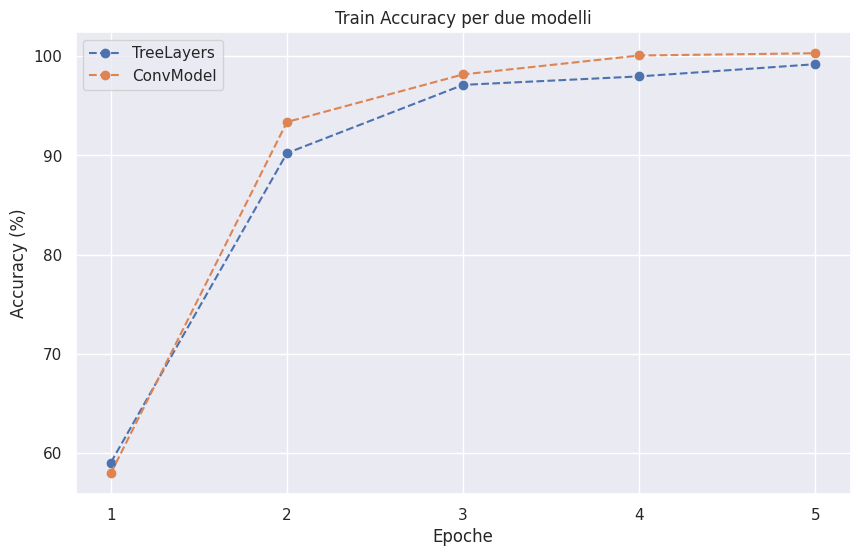

In [42]:

# train threelayer vs cnn accuracy
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy3, label = "TreeLayers",marker='o', linestyle='--')
plt.plot(epochs, cnn_acc, label = "ConvModel",marker='o', linestyle='--')

plt.xlabel('Epoche')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()

plt.title('Train Accuracy per due modelli')

plt.show()

In [ ]:
# Learning rate change
learning_rates = [0.0001,0.001, 0.01, 0.1]
num_epochs = 5

model = ThreeLayerModel()
criterion = nn.CrossEntropyLoss()

losses_dict = {lr: [] for lr in learning_rates}

# Train the model with each learning rate
for lr in learning_rates:
    print(f'Training with Learning Rate: {lr}')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss,accuracy,norms = train_model(model, num_epochs, trainloader, criterion, optimizer)
    losses_dict[lr].append(loss)

Training with Learning Rate: 0.0001
Epoch: 1 | Loss: 2.442 | Train Accuracy: 45.105 | Time: 3.27
Epoch: 2 | Loss: 1.149 | Train Accuracy: 80.095 | Time: 3.80
Epoch: 3 | Loss: 0.655 | Train Accuracy: 89.332 | Time: 3.40
Epoch: 4 | Loss: 0.438 | Train Accuracy: 93.750 | Time: 3.13
Epoch: 5 | Loss: 0.328 | Train Accuracy: 95.181 | Time: 3.12
Training with Learning Rate: 0.001
Epoch: 1 | Loss: 0.563 | Train Accuracy: 84.287 | Time: 4.36
Epoch: 2 | Loss: 0.207 | Train Accuracy: 94.955 | Time: 3.75
Epoch: 3 | Loss: 0.126 | Train Accuracy: 97.113 | Time: 3.51
Epoch: 4 | Loss: 0.062 | Train Accuracy: 99.548 | Time: 3.50
Epoch: 5 | Loss: 0.047 | Train Accuracy: 99.699 | Time: 4.50
Training with Learning Rate: 0.01
Epoch: 1 | Loss: 3.484 | Train Accuracy: 37.902 | Time: 3.76
Epoch: 2 | Loss: 1.314 | Train Accuracy: 55.397 | Time: 3.71
Epoch: 3 | Loss: 1.203 | Train Accuracy: 60.090 | Time: 4.53
Epoch: 4 | Loss: 0.841 | Train Accuracy: 69.302 | Time: 3.89
Epoch: 5 | Loss: 0.935 | Train Accuracy: 

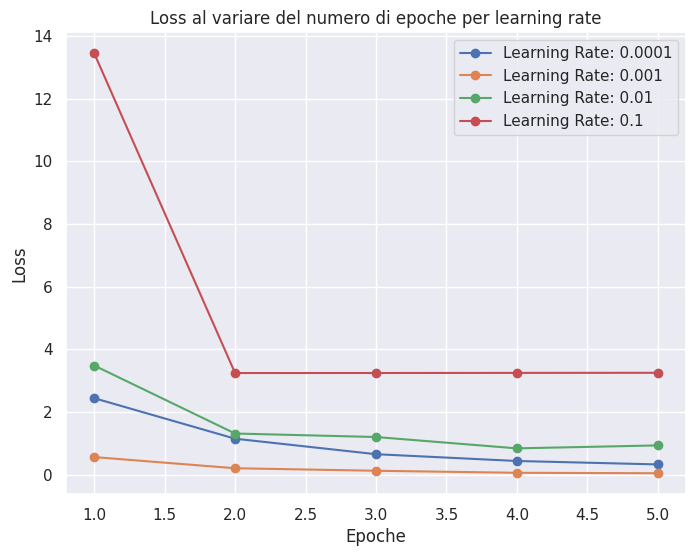

In [ ]:
# Plotting the loss with different learning

plt.figure(figsize=(8, 6))
for i, lr in enumerate(learning_rates):
    losses = losses_dict[lr][0]
    plt.plot(range(1, num_epochs + 1), losses, marker='o', label=f'Learning Rate: {lr}')

plt.title('Loss as the number of epochs varies for learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
learning_rates = [0.0001,0.001, 0.01, 0.1]
num_epochs = 5

model = ConvModel()
criterion = nn.CrossEntropyLoss()

losses_dict = {lr: [] for lr in learning_rates}

# Allenare il modello con ciascun learning rate
for lr in learning_rates:
    print(f'Training with Learning Rate: {lr}')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss,accuracy,norms = train_model(model, num_epochs, trainloader, criterion, optimizer)
    losses_dict[lr].append(loss)

Training with Learning Rate: 0.0001
Epoch: 1 | Loss: 3.129 | Train Accuracy: 25.025 | Time: 56.91
Epoch: 2 | Loss: 1.839 | Train Accuracy: 66.290 | Time: 58.47
Epoch: 3 | Loss: 0.753 | Train Accuracy: 85.090 | Time: 55.61
Epoch: 4 | Loss: 0.433 | Train Accuracy: 91.566 | Time: 54.06
Epoch: 5 | Loss: 0.277 | Train Accuracy: 96.135 | Time: 54.54
Training with Learning Rate: 0.001
Epoch: 1 | Loss: 0.675 | Train Accuracy: 83.936 | Time: 53.82
Epoch: 2 | Loss: 0.095 | Train Accuracy: 98.117 | Time: 51.28
Epoch: 3 | Loss: 0.038 | Train Accuracy: 100.301 | Time: 50.99
Epoch: 4 | Loss: 0.005 | Train Accuracy: 101.130 | Time: 50.31
Epoch: 5 | Loss: 0.001 | Train Accuracy: 101.205 | Time: 62.80
Training with Learning Rate: 0.01
Epoch: 1 | Loss: 4.881 | Train Accuracy: 6.627 | Time: 55.68
Epoch: 2 | Loss: 3.220 | Train Accuracy: 3.238 | Time: 52.56
Epoch: 3 | Loss: 3.220 | Train Accuracy: 4.217 | Time: 52.51
Epoch: 4 | Loss: 3.220 | Train Accuracy: 3.087 | Time: 51.65
Epoch: 5 | Loss: 3.219 | Tra

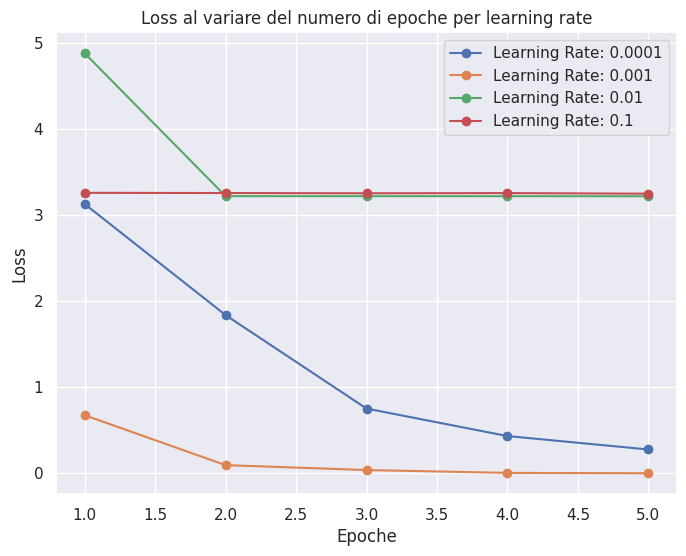

In [ ]:
plt.figure(figsize=(8, 6))
for i, lr in enumerate(learning_rates):
    losses = losses_dict[lr][0]
    plt.plot(range(1, num_epochs + 1), losses, marker='o', label=f'Learning Rate: {lr}')

plt.title('Loss as the number of epochs varies for learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Test 

In [ ]:
# Function to test a model on the test set, the accuracy and loss of the test are returned in a dictionary.
def test_model(model,testloader, criterion, device):

    model.to(device)

    test_results = {'accuracy': [], 'loss': []}
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_results['loss'].append(test_loss / len(testloader))
    test_results['accuracy'].append(100 * correct / total)

    return test_results

In [48]:
def plot_train_test_results(train_results, test_results, title):
    epochs = range(1, len(train_results['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_results['accuracy'], 'go-', label='Train Accuracy')
    plt.axhline(y=test_results['accuracy'], color='red', label='Test Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_results['loss'], 'go-', label='Train Loss')
    plt.axhline(y=test_results['loss'], color='red', label='Test Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.suptitle('Train vs Test')
    plt.show()

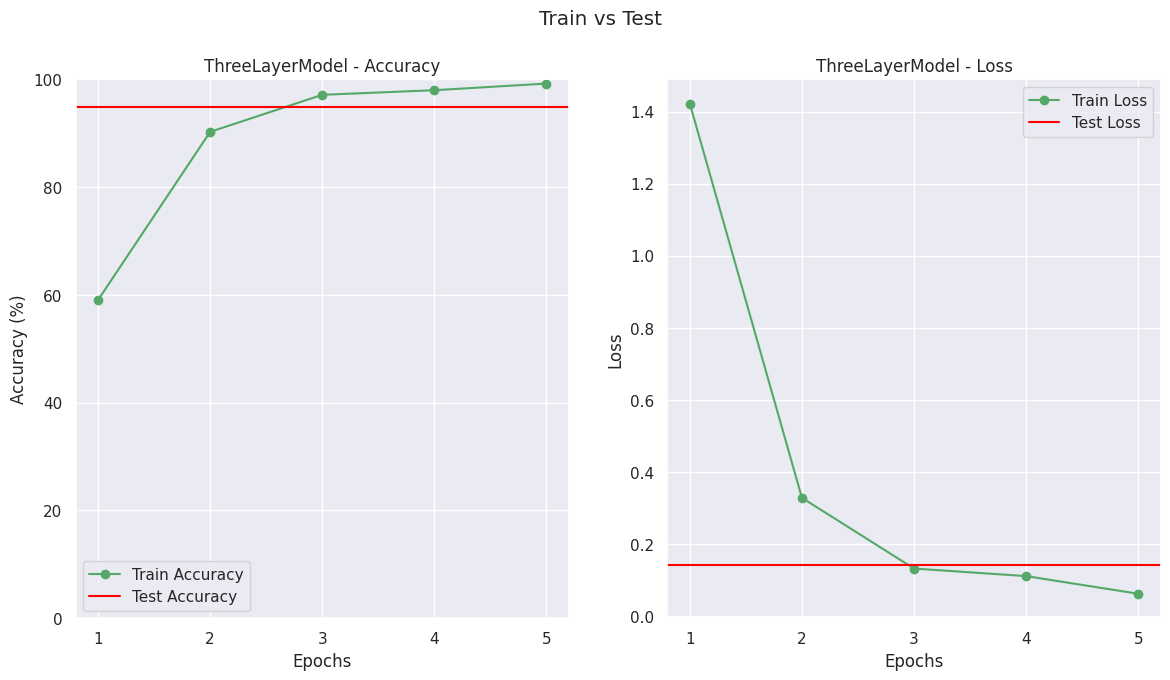

In [ ]:
# ThreeLayer Model Train and Test Graph

optimizer = torch.optim.Adam(threelayermodel.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_threelayer = test_model(threelayermodel, testloader, criterion, device)
train_threelayer = {'accuracy': accuracy3, 'loss': loss3}
plot_train_test_results(train_threelayer, test_threelayer, type(threelayermodel).__name__)


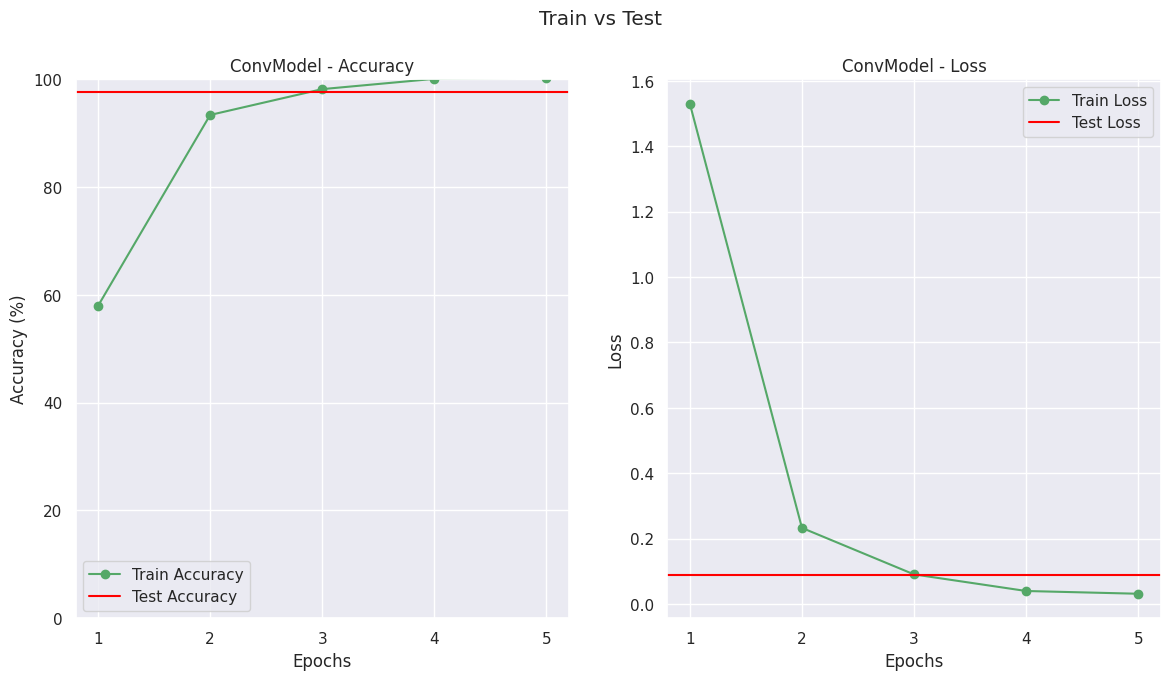

In [50]:
train_cnn = {'accuracy': cnn_acc, 'loss': cnn_loss}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_cnn = test_model(cnn, testloader, criterion, device)
plot_train_test_results(train_cnn, test_cnn, type(cnn).__name__)

Overfitting is likely, mainly due to the limited amount of data available. We reduce the complexity of the model to overcome this problem.

In [51]:
# Two Layer fully connected neural network

class TwoLayerModel(nn.Module):

  def __init__(self):
    super(TwoLayerModel,self).__init__()

    self.l1 = nn.Linear(128*128,128)
    self.l2 = nn.Linear(128,24)

  def forward(self,x):
    x = x.flatten(start_dim=1)
    x = self.l1(x)
    x = F.relu(x)
    x = self.l2(x)

    return x

In [52]:
TwoLayer = TwoLayerModel()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(TwoLayer.parameters(), lr=0.001)

loss2,accuracy2, W_adam = train_model(TwoLayer, 5, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.348 | Train Accuracy: 63.780 | Time: 1.74
Epoch: 2 | Loss: 0.306 | Train Accuracy: 93.122 | Time: 2.01
Epoch: 3 | Loss: 0.152 | Train Accuracy: 97.139 | Time: 3.48
Epoch: 4 | Loss: 0.097 | Train Accuracy: 99.247 | Time: 1.88
Epoch: 5 | Loss: 0.058 | Train Accuracy: 100.301 | Time: 2.18


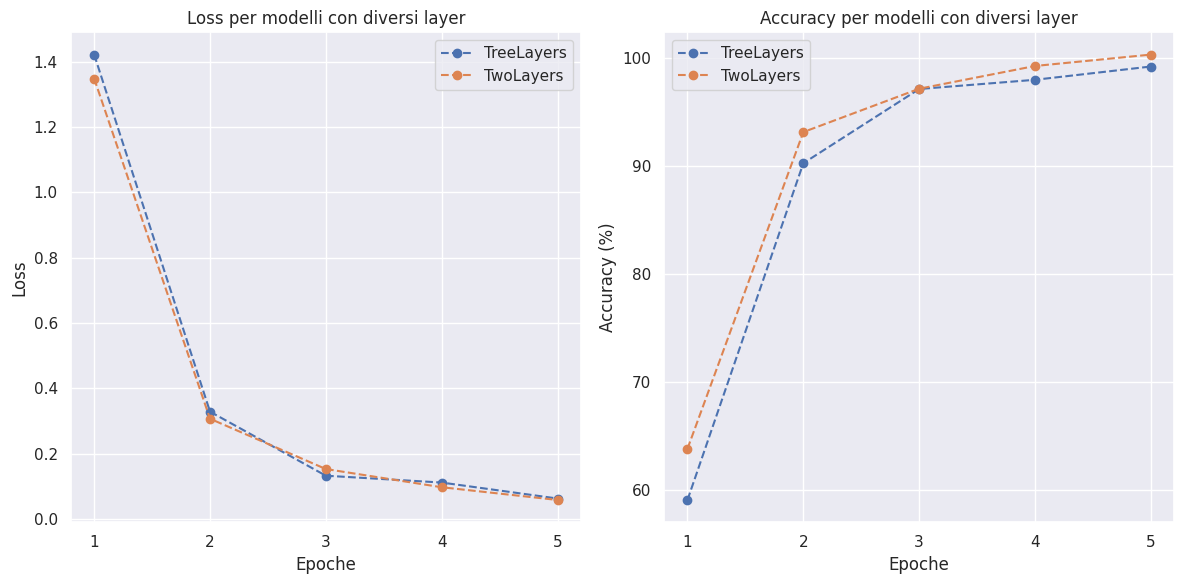

In [ ]:
# Plot of loss and accuracy as the number of layers varies
epochs = [1,2,3,4,5]
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss3, label = "TreeLayers",marker='o', linestyle='--')
plt.plot(epochs, loss2, label = "TwoLayers",marker='o', linestyle='--')

plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Loss per modelli con diversi layer')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy3, label = "TreeLayers",marker='o', linestyle='--')
plt.plot(epochs, accuracy2, label = "TwoLayers",marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for models with multiple layers')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

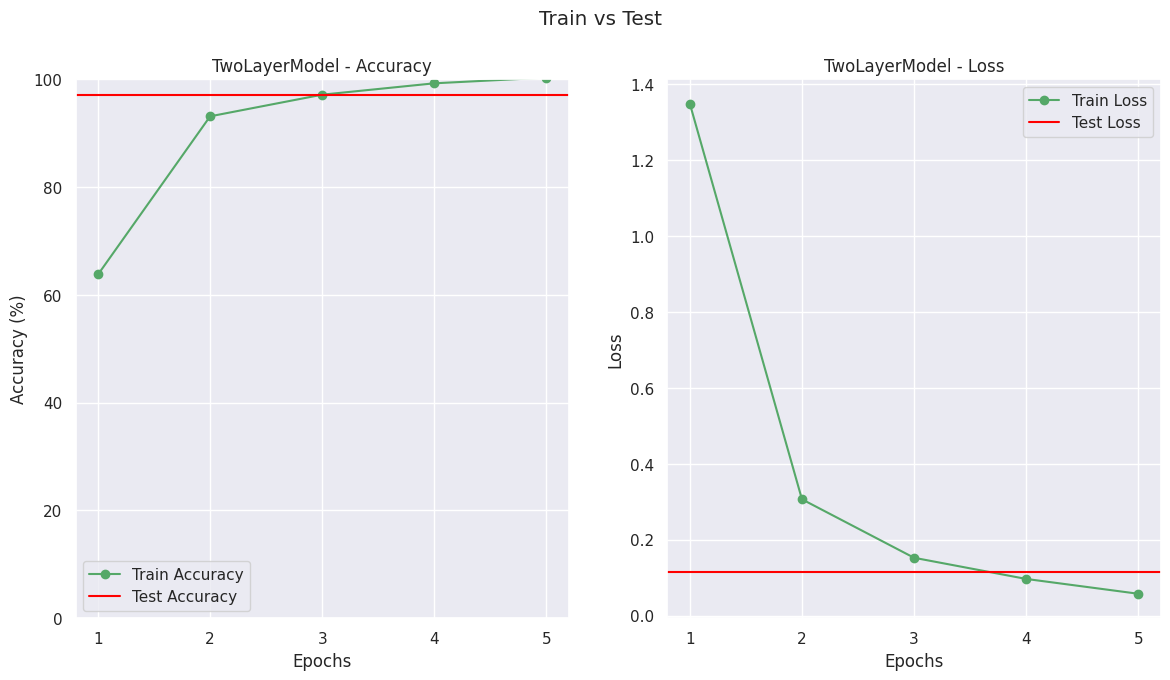

In [ ]:
# Test TwoLayer
optimizer = torch.optim.Adam(TwoLayer.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_twolayer = test_model(TwoLayer, testloader, criterion, device)
train_twolayer = {'accuracy' : accuracy2,'loss': loss2}
plot_train_test_results(train_twolayer, test_twolayer, type(TwoLayer).__name__)

As we can see a model with 2 fully connected layers is too simple to correctly classify this problem.

A solution could be adding new data via **data augmentation**.

### Data Augmentation

In [ ]:
# Various transformations to apply to images

transformations = {
    'rotation1': transforms.RandomRotation((30,70)), # rotazioni
    'rotation2': transforms.RandomRotation((-50,-30)),
    'crop': transforms.RandomResizedCrop(size= (128,128), scale=(0.8, 1.0)), # Ritaglio e ridimensionamento (scaling)
    'perspective1': transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # cambio della prospettiva
    'perspective2': transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    'traslation1': transforms.RandomAffine(degrees = 0, translate = (0.4,0)),  # traslazione orizzontale
    'traslation2': transforms.RandomAffine(degrees = 0, translate = (0,0.4)),  # traslazione verticale
    'traslation3': transforms.RandomAffine(degrees = 0, translate = (0.4,0), scale = (0.8,1.0)), # traslazione orizzontale + scaling
    'compose': transforms.RandomAffine(degrees = 30, translate = (0,0.3), scale = (0.8,1.0)), # traslazione verticale + scaling + rotazione
    'compose2': transforms.RandomAffine(degrees = 30, translate = (0.3,0), scale = (0.8,1.0)) # traslazione orizzontale + scaling + rotazione

}

In [ ]:
# Creating new images

for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)

    #Iterate on each image in the category folder
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Upload the image
        image = Image.open(image_path)

        # Applying transformations
        for transform_name in transformations:

                transformation = transformations[transform_name]
                augmented_image = transformation(image)

                # Creating a new name for transformed images
                base_name, ext = os.path.splitext(image_name)
                new_image_name = f"{base_name}_{transform_name}{ext}"
                new_image_path = os.path.join(category_path, new_image_name)

                # Saving transformed images
                augmented_image.save(new_image_path)

In [ ]:
# New dataset dimension
classes = sorted(os.listdir(dataset_dir))

first_class_dir = next(filter(lambda x: count_images_in_folder(os.path.join(dataset_dir, x)) > 0, classes), None)

class_image_counts = {class_name: count_images_in_folder(os.path.join(dataset_dir, class_name)) for class_name in classes}
total_images = sum(map(lambda x: count_images_in_folder(os.path.join(dataset_dir, x)), classes))

# Number of images
print(f" Total number of images: {total_images}")

# Number of images per class
for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}': {count} images")

Numero totale di immagini nel dataset: 18425
Classe 'a': 770 immagini
Classe 'b': 770 immagini
Classe 'c': 770 immagini
Classe 'd': 770 immagini
Classe 'e': 770 immagini
Classe 'f': 770 immagini
Classe 'g': 770 immagini
Classe 'h': 770 immagini
Classe 'i': 770 immagini
Classe 'k': 770 immagini
Classe 'l': 770 immagini
Classe 'm': 770 immagini
Classe 'n': 770 immagini
Classe 'o': 770 immagini
Classe 'p': 770 immagini
Classe 'q': 770 immagini
Classe 'r': 770 immagini
Classe 's': 770 immagini
Classe 't': 715 immagini
Classe 'u': 770 immagini
Classe 'v': 770 immagini
Classe 'w': 770 immagini
Classe 'x': 770 immagini
Classe 'y': 770 immagini


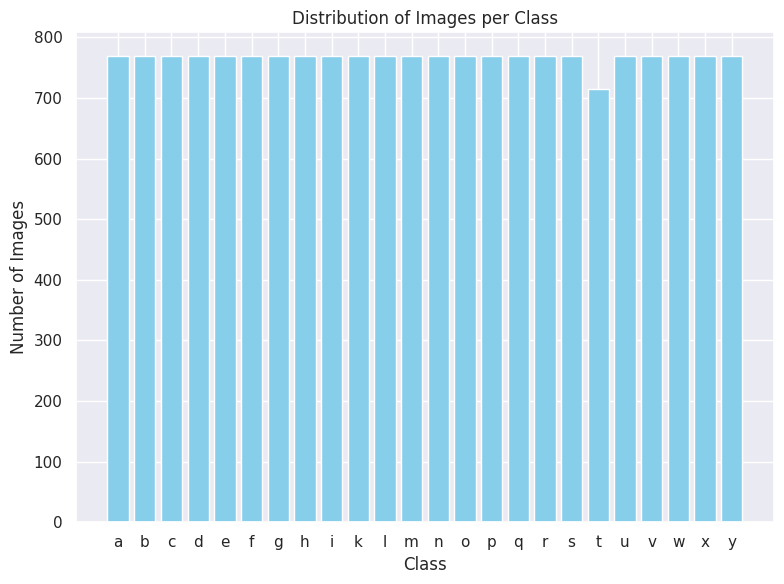

In [ ]:
# Images distribution
class_names = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks()
plt.tight_layout()

plt.show()

In [ ]:
def show_images_from_paths(base_name, transform_names, dataset_dir):

    transform_names = sorted(transform_names)

    num_images = len(transform_names)
    num_cols = 3
    num_rows = (num_images // num_cols) + (1 if num_images % num_cols != 0 else 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 7))

    for i, transform_name in enumerate(transform_names):

        # Let's build the full path of the image
        image_path = os.path.join(dataset_dir, f"{base_name}_{transform_name}.jpeg")

        # Check if the file exists
        if os.path.exists(image_path):
            #Upload the image
            image = Image.open(image_path)

            # Image position in grid
            row = i // num_cols
            col = i % num_cols

            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{transform_name}")
        else:
            print(f"File does not exists: {image_path}")

    for j in range(num_images, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()


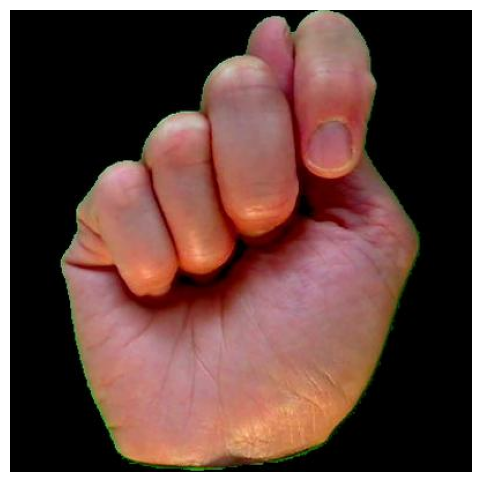

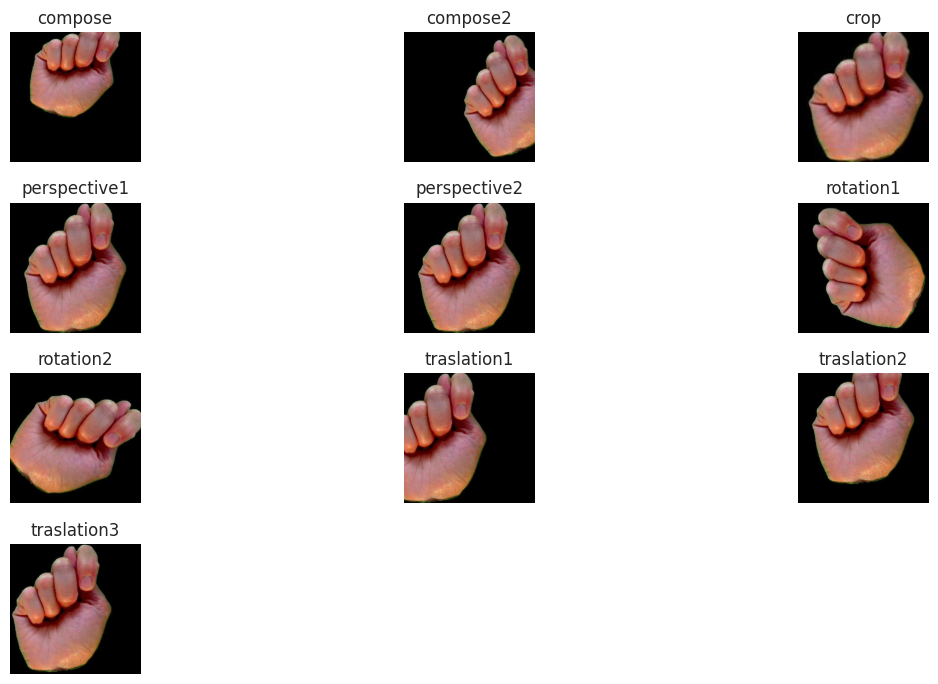

In [ ]:

# Original Image
original_image = '/content/asl_dataset/t/hand1_t_bot_seg_1_cropped.jpeg'

img = cv2.imread(original_image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Transformed Image
base_name = '/content/asl_dataset/t/hand1_t_bot_seg_1_cropped'
transform_names = {'rotation1','rotation2','crop','perspective1','perspective2','traslation1','traslation2','traslation3','compose','compose2'}

show_images_from_paths(base_name,transform_names,dataset_dir)

In [ ]:
# Process the images

target_size = (128, 128)
X, y, reverse_label_mapping = process_images(dataset_dir, target_size) #normalize and transform in black and white
scaler = StandardScaler()
X = scaler.fit_transform(X) # standardization


In [ ]:
# Load training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dataset dimensions
print(f"Dataset dimensions:")
print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set: X_test {X_test.shape}, y_test {y_test.shape}")

Dimensioni dei set di dati:
Training set: X_train (12897, 16384), y_train (12897,)
Test set: X_test (5528, 16384), y_test (5528,)


Creating the augmented dataset

In [82]:
batch_size = 32

In [ ]:
image_height = 128
image_width = 128
num_channels = 1
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).reshape(image_height,image_width,num_channels)),
    transforms.ToTensor(),
    transforms.Lambda( lambda x: x.float())# Converts images to tensors
])

# Train and test dataset
train_dataset = Dataset(X_train, y_train, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Dataset(X_test, y_test, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 128, 128])
Image label dimensions: torch.Size([32])




### Test on the augmented data of the already developed models

Testing Supervised Learning Models

In [85]:
# test knn
accuracy_test_knn = knn.score(X_test, y_test)

In [ ]:
# test gaussian naive bayes
y_pred = gnb.predict(X_test)

# Accuracy
accuracy_test_gnb = accuracy_score(y_test, y_pred)

In [ ]:
# test random forest
y_pred = best_model.predict(X_test)

# Test Accuracy
accuracy_test_rf = accuracy_score(y_test, y_pred)

<Figure size 600x600 with 0 Axes>

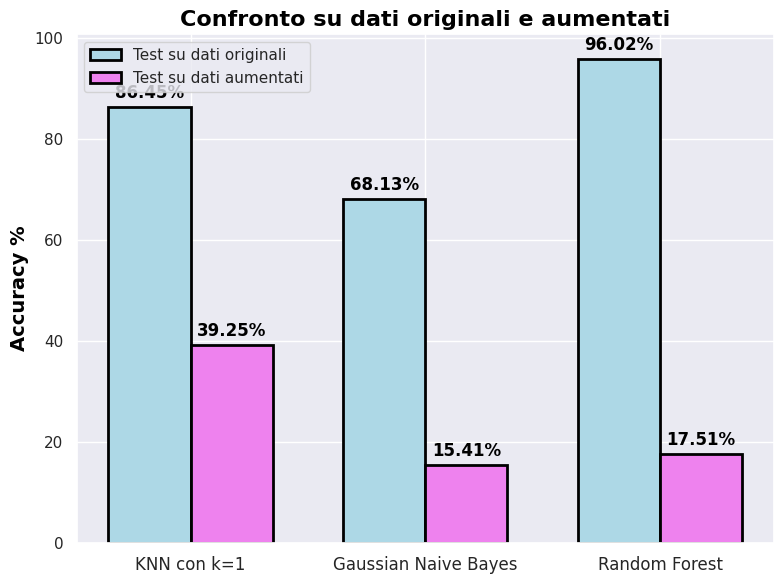

In [ ]:

plt.figure(figsize=(6, 6))
# test originale
test_knn = float(test_scores[-1])*100
test_gnb = accuracy_gnb *100
test_rf = accuracy_test_randomf *100
accuracy_knn = accuracy_test_knn *100
accuracy_gnb = accuracy_test_gnb *100
accuracy_rf = accuracy_test_rf *100

models = ['KNN con k=1','Gaussian Naive Bayes','Random Forest']
original = [test_knn, test_gnb, test_rf]
augmented = [accuracy_knn,accuracy_gnb, accuracy_rf]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, original, width, label='Test on original data', color='lightblue', edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, augmented, width, label='Test on augmented data', color='violet', edgecolor='black', linewidth=2)

# Adding labels and title
ax.set_ylabel('Accuracy %', fontsize=14, fontweight='bold', color='black')
ax.set_title('Comparison on original and augmented data', fontsize=16, fontweight='bold', color='black')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Adding labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%',
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

add_labels(bars1)
add_labels(bars2)

# Show plot

plt.tight_layout()
plt.show()

Test of neaural networks

In [89]:
def get_predictions(model,testloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  model.eval()

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)

          logits = model(images)
          _, preds = torch.max(logits, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  return np.array(all_preds), np.array(all_labels)

In [ ]:
# Test ThreeLayer

optimizer = torch.optim.Adam(threelayermodel.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_threelayer_new = test_model(threelayermodel, testloader, criterion, device) # testiamo il modello


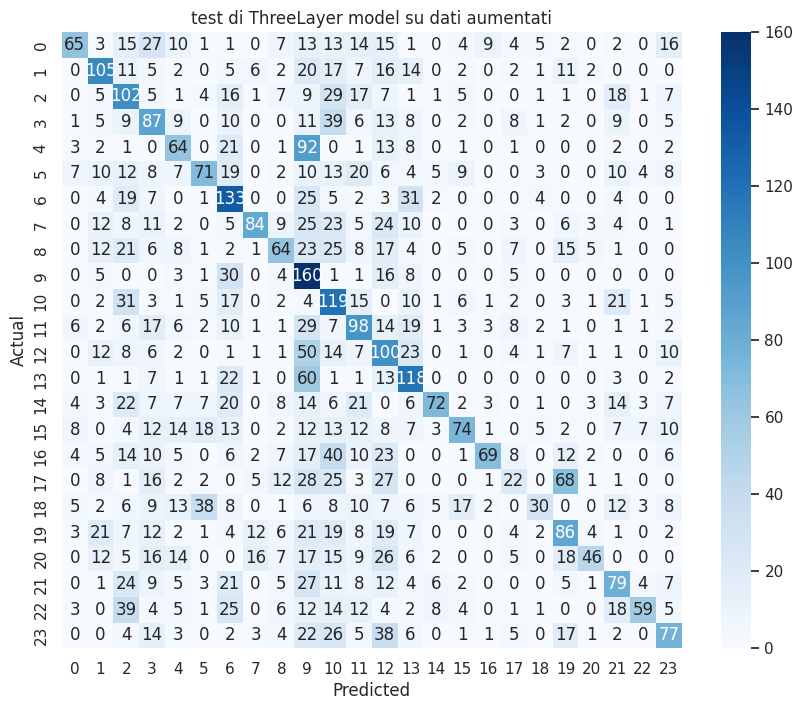

In [ ]:
preds, labels = get_predictions(threelayermodel,testloader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ThreeLayer model test on augmented data')
plt.show()

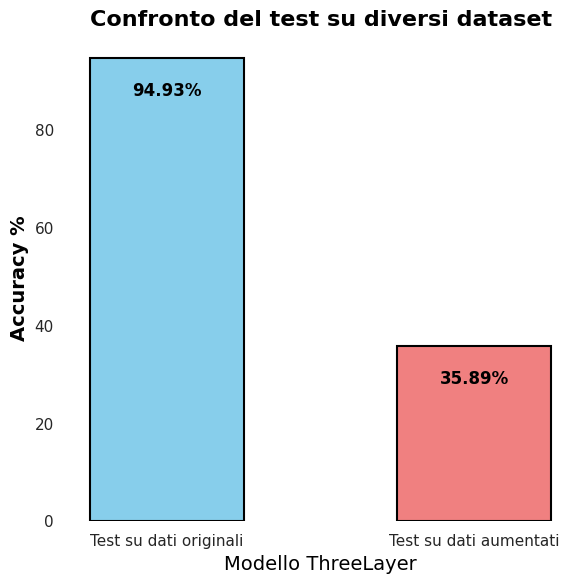

In [ ]:
plt.figure(figsize=(6, 6))
accuracy1 = float(test_threelayer['accuracy'][0])
accuracy2 = float(test_threelayer_new['accuracy'][0])
models = ['Test on original data', 'Test on augmented data']

bars = plt.bar(models,(accuracy1,accuracy2), color=['skyblue', 'lightcoral'],width = 0.5, edgecolor='black', linewidth=1.5)
# Adding labels and title
plt.xlabel('ThreeLayer Model',fontsize=14, color='black')
plt.ylabel('Accuracy %', fontsize=14, fontweight='bold', color='black')
plt.title('Test comparison on different datasets', fontsize=16, fontweight='bold', color='black')

for bar,acc in zip(bars,(accuracy1,accuracy2)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{acc:.2f}%',
             ha='center', va='top', fontsize=12, color='black', fontweight='bold')

plt.box(False)
plt.tight_layout()
plt.show()

In [ ]:
# Test of the convolutional model on the augmented data

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_cnn_new = test_model(cnn, testloader, criterion, device) # testiamo il modello

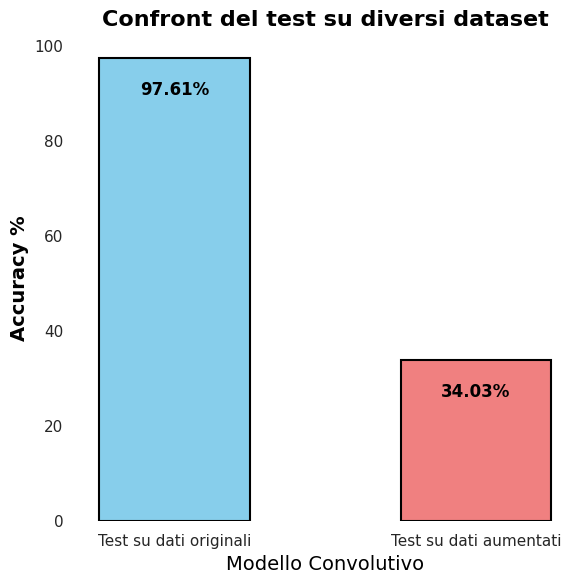

In [ ]:
# plot 
plt.figure(figsize=(6, 6))
accuracy1 = float(test_cnn['accuracy'][0])
accuracy2 = float(test_cnn_new['accuracy'][0])
models = ['Test on original data', 'Test on augmented data']

bars = plt.bar(models,(accuracy1,accuracy2), color=['skyblue', 'lightcoral'],width = 0.5, edgecolor='black', linewidth=1.5)

plt.xlabel('Convolutional Model',fontsize=14, color='black')
plt.ylabel('Accuracy %', fontsize=14, fontweight='bold', color='black')
plt.title('Test comparison on different datasets', fontsize=16, fontweight='bold', color='black')

for bar,acc in zip(bars,(accuracy1,accuracy2)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{acc:.2f}%',
             ha='center', va='top', fontsize=12, color='black', fontweight='bold')

plt.box(False)
plt.tight_layout()
plt.show()

### Convolutional Neural Networks


In [95]:
class SimpleCNNModel(nn.Module):
  def __init__(self):
    super(SimpleCNNModel,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels= 8, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.l1 = nn.Linear(16*30*30,512)
    self.l2 = nn.Linear(512,24)

  def forward(self, x):

        # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))  # BSx1x128x128 => BSx16x63x63
        x = self.pool(F.relu(self.conv2(x)))  # BSx16x63x63 => BSx32x30x30


        # Flatten
        x = x.flatten(start_dim=1)  # BSx128x14x14 => BSx25088

        # Fully connected layers with dropout
        x = F.relu(self.l1(x))  # BSx25088 => BSx512

        x = self.l2(x)  # BSx512 => BSx24

        # Softmax output
        out = F.log_softmax(x, dim=1)

        return out

In [ ]:
# Training
CNN2 = SimpleCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN2.parameters(), lr=0.001)

loss_cnn1,accuracy_cnn1,norms = train_model(CNN2, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.532 | Train Accuracy: 52.644 | Time: 105.22
Epoch: 2 | Loss: 0.551 | Train Accuracy: 81.754 | Time: 117.54
Epoch: 3 | Loss: 0.235 | Train Accuracy: 92.424 | Time: 132.93
Epoch: 4 | Loss: 0.106 | Train Accuracy: 96.790 | Time: 137.70
Epoch: 5 | Loss: 0.054 | Train Accuracy: 98.682 | Time: 133.90
Epoch: 6 | Loss: 0.072 | Train Accuracy: 98.131 | Time: 133.92
Epoch: 7 | Loss: 0.047 | Train Accuracy: 98.736 | Time: 133.43
Epoch: 8 | Loss: 0.047 | Train Accuracy: 98.627 | Time: 140.27
Epoch: 9 | Loss: 0.060 | Train Accuracy: 98.488 | Time: 133.27
Epoch: 10 | Loss: 0.011 | Train Accuracy: 99.953 | Time: 135.97


{'accuracy': [52.64423076923077, 81.75403225806451, 92.42400744416874, 96.78970223325062, 98.68176178660049, 98.1312034739454, 98.73604218362283, 98.62748138957816, 98.48790322580645, 99.95347394540943], 'loss': [1.532108407162555, 0.5507126477530813, 0.2349056228209592, 0.10634613272337655, 0.05350392549264039, 0.07236679560370818, 0.04713752005126696, 0.04659334432428169, 0.06042266307978424, 0.011266990990596639]} {'accuracy': [84.65991316931982], 'loss': [0.7061821819213084]}


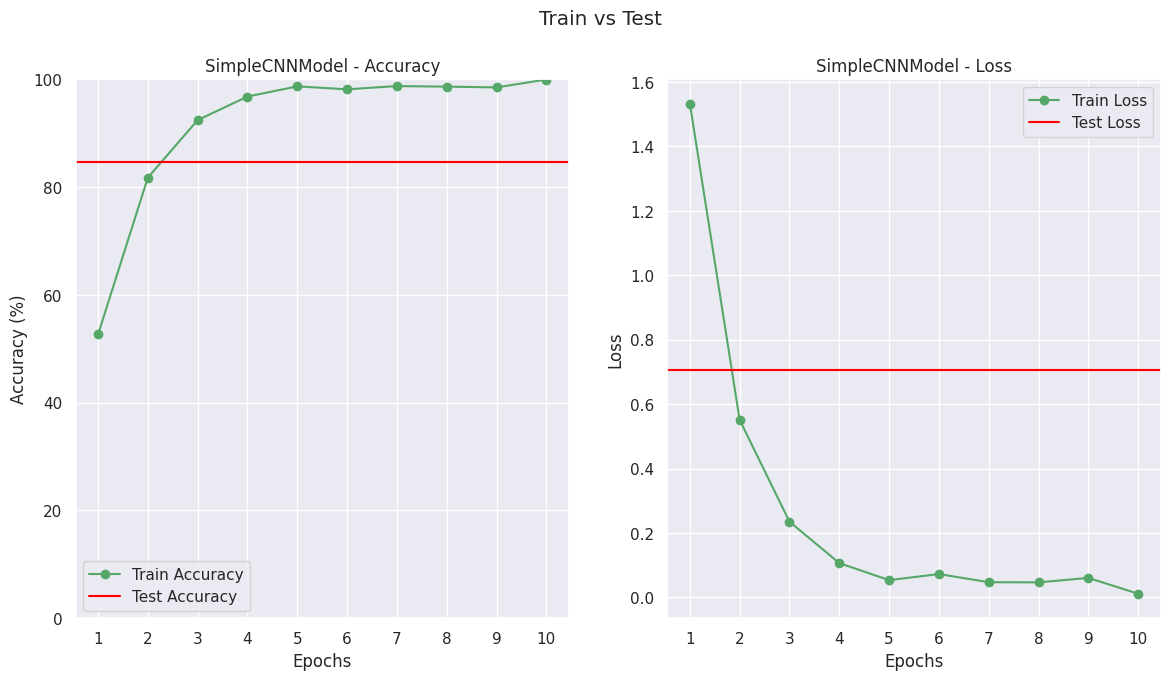

In [ ]:
# Test 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_simple_cnn = test_model(CNN2,testloader,criterion,device)
train_simple_cnn = {'accuracy':accuracy_cnn1,'loss': loss_cnn1}

print(train_simple_cnn,test_simple_cnn)
plot_train_test_results(train_simple_cnn, test_simple_cnn, type(CNN2).__name__)

In [98]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 24)


    def forward(self, x):

        # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))  # BSx1x128x128 => BSx32x63x63
        x = self.pool(F.relu(self.conv2(x)))  # BSx32x63x63 => BSx64x30x30
        x = self.pool(F.relu(self.conv3(x)))  # BSx64x30x30 => BSx128x14x14

        # Flatten
        x = x.view(-1, 128 * 14 * 14)  # BSx128x14x14 => BSx25088

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))  # BSx25088 => BSx512

        x = self.fc2(x)  # BSx512 => BSx24

        # Softmax output
        out = F.log_softmax(x, dim=1)

        return out

In [ ]:
# training
CNN = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

loss,accuracy, norms = train_model(CNN, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.195 | Train Accuracy: 61.957 | Time: 531.09
Epoch: 2 | Loss: 0.331 | Train Accuracy: 88.586 | Time: 567.49
Epoch: 3 | Loss: 0.144 | Train Accuracy: 95.293 | Time: 611.78
Epoch: 4 | Loss: 0.095 | Train Accuracy: 97.053 | Time: 633.52
Epoch: 5 | Loss: 0.065 | Train Accuracy: 98.310 | Time: 625.86
Epoch: 6 | Loss: 0.051 | Train Accuracy: 98.627 | Time: 612.69
Epoch: 7 | Loss: 0.051 | Train Accuracy: 98.674 | Time: 608.15
Epoch: 8 | Loss: 0.033 | Train Accuracy: 99.225 | Time: 609.78
Epoch: 9 | Loss: 0.031 | Train Accuracy: 99.302 | Time: 613.64
Epoch: 10 | Loss: 0.032 | Train Accuracy: 99.403 | Time: 608.19


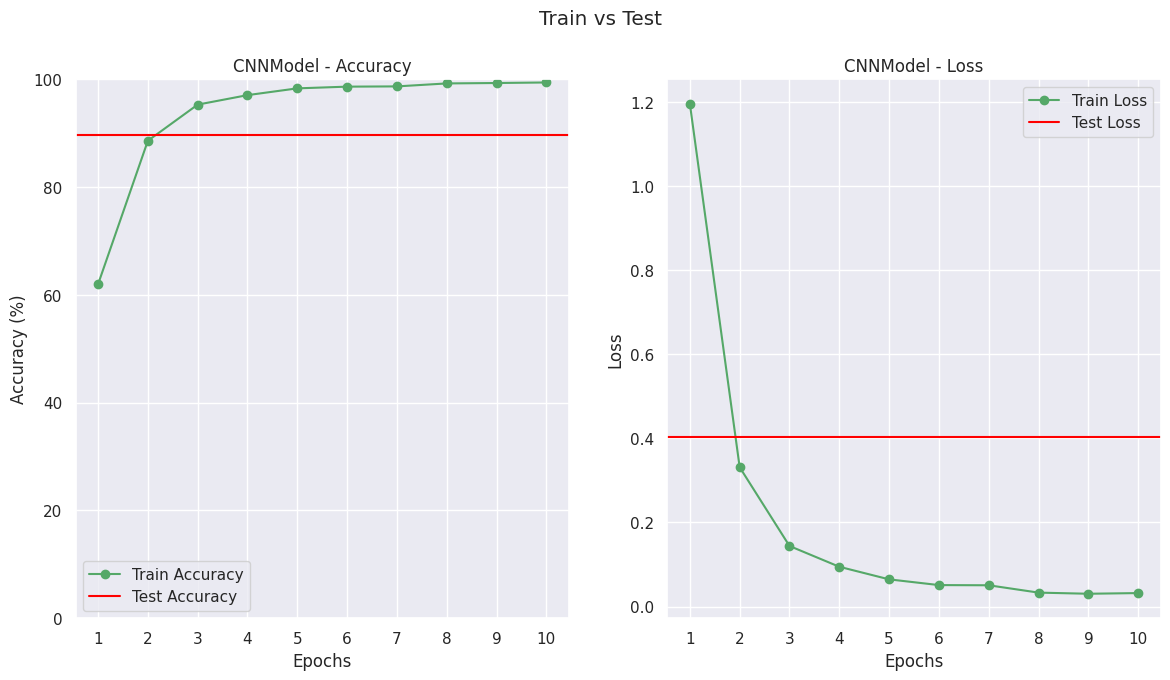

In [ ]:
# Test 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_res = test_model(CNN,testloader,criterion,device)
train_res = {'accuracy': accuracy,'loss': loss}

plot_train_test_results(train_res, test_res, type(CNN).__name__)

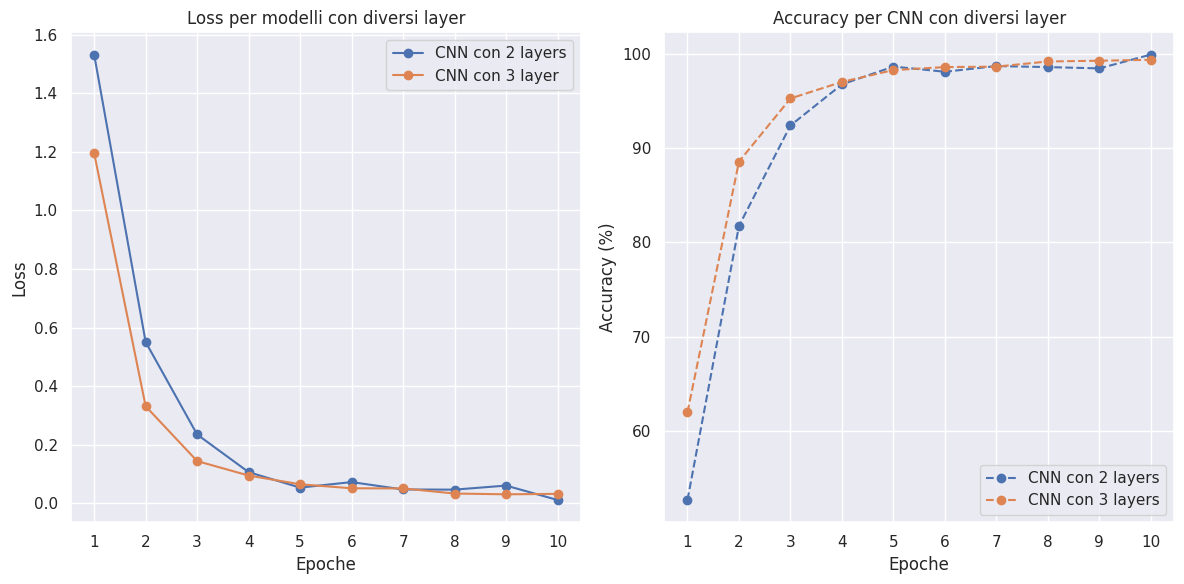

In [ ]:
#Comparison between the two models
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_cnn1, label = "CNN with 2 layers",marker='o', linestyle='-')
plt.plot(epochs, loss, label = "CNN with 3 layer",marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for models with different layers')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_cnn1, label = "CNN with 2 layers",marker='o', linestyle='--')
plt.plot(epochs, accuracy, label = "CNN with 3 layers",marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for CNN with multiple layers')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

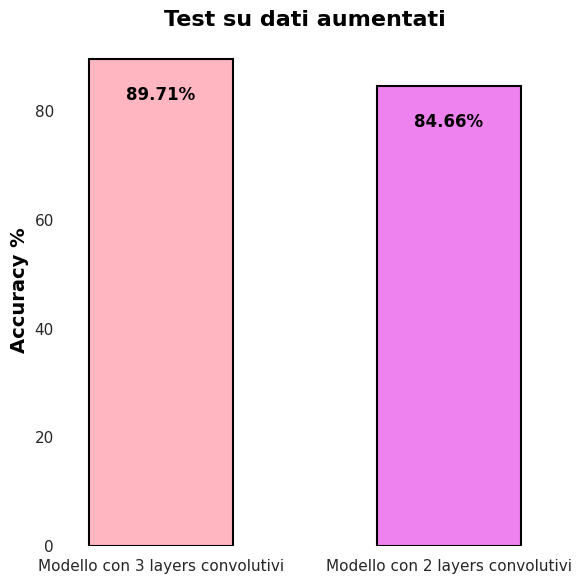

In [ ]:
# Barplot test cnn vs threelayer

plt.figure(figsize=(6, 6))
accuracy1 = float(test_res['accuracy'][-1])
accuracy2 = float(test_simple_cnn['accuracy'][0])

models = ['3-layer Convolutional model','2-layer Convolutional model']

bars = plt.bar(models,(accuracy1,accuracy2), color=['lightpink', 'violet'], width = 0.5, edgecolor='black', linewidth=1.5)

plt.ylabel('Accuracy %', fontsize=14, fontweight='bold', color='black')
plt.title('Test su dati aumentati', fontsize=16, fontweight='bold', color='black')


for bar,acc in zip(bars,(accuracy1,accuracy2)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{acc:.2f}%',
             ha='center', va='top', fontsize=12, color='black',fontweight='bold')


plt.box(False)
plt.tight_layout()
plt.show()


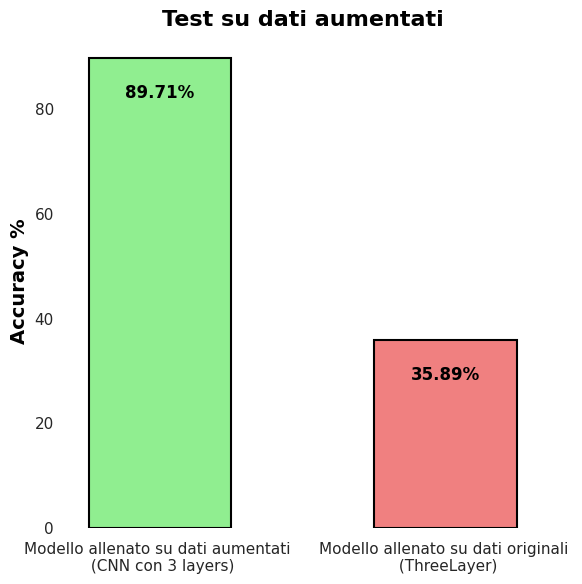

In [ ]:
# Barplot test cnn vs threelayer

plt.figure(figsize=(6, 6))
accuracy1 = float(test_res['accuracy'][-1])
accuracy2 = float(test_threelayer_new['accuracy'][0])

models = ['Model trained on augmented data \n (CNN with 3 layers)','Model trained on original data \n (ThreeLayer)']


bars = plt.bar(models,(accuracy1,accuracy2), color=['lightgreen', 'lightcoral'], width = 0.5, edgecolor='black', linewidth=1.5)

plt.ylabel('Accuracy %', fontsize=14, fontweight='bold', color='black')
plt.title('Test on augmented data', fontsize=16, fontweight='bold', color='black')


for bar,acc in zip(bars,(accuracy1,accuracy2)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{acc:.2f}%',
             ha='center', va='top', fontsize=12, color='black',fontweight='bold')

plt.box(False)
plt.tight_layout()
plt.show()


### Analysis of errors made by the model

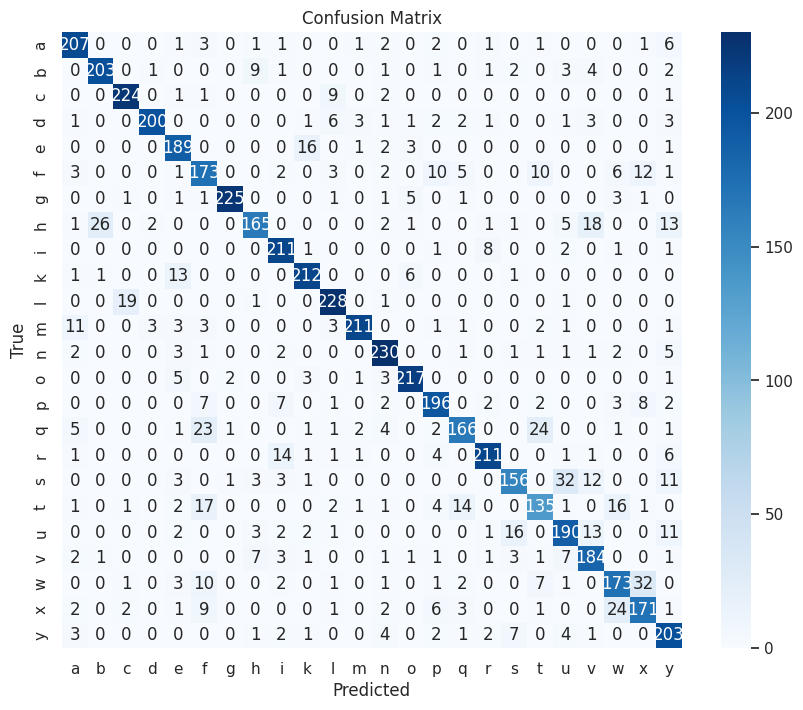

Class 0 (a): 20 errors
Class 1 (b): 25 errors
Class 2 (c): 14 errors
Class 3 (d): 25 errors
Class 4 (e): 23 errors
Class 5 (f): 55 errors
Class 6 (g): 15 errors
Class 7 (h): 70 errors
Class 8 (i): 14 errors
Class 9 (k): 22 errors
Class 10 (l): 22 errors
Class 11 (m): 29 errors
Class 12 (n): 20 errors
Class 13 (o): 15 errors
Class 14 (p): 34 errors
Class 15 (q): 66 errors
Class 16 (r): 30 errors
Class 17 (s): 66 errors
Class 18 (t): 61 errors
Class 19 (u): 51 errors
Class 20 (v): 30 errors
Class 21 (w): 61 errors
Class 22 (x): 52 errors
Class 23 (y): 28 errors
Class with most errors: 7 (h) with 70 errors su 5528


In [ ]:
#preds, true_labels = get_predictions(CNN,testloader)
preds, true_labels = get_predictions(CNN2,testloader)
cm = confusion_matrix(true_labels, preds)

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Analyze the classes with the highest number of errors
num_classes = len(classes)
errors_per_class = np.sum(cm, axis=1) - np.diag(cm)
for i in range(num_classes):
    print(f'Class {i} ({classes[i]}): {errors_per_class[i]} errors')

# Optional: Find and print the classes with the most incorrect predictions
most_errors_class_idx = np.argmax(errors_per_class)
print(f'Class with most errors: {most_errors_class_idx} ({classes[most_errors_class_idx]}) with {errors_per_class[most_errors_class_idx]} errors su {len(y_test)}')

([<matplotlib.axis.XTick at 0x7d786080d330>,
 [Text(0, 0, 'a'),
  Text(1, 0, 'b'),
  Text(2, 0, 'c'),
  Text(3, 0, 'd'),
  Text(4, 0, 'e'),
  Text(5, 0, 'f'),
  Text(6, 0, 'g'),
  Text(7, 0, 'h'),
  Text(8, 0, 'i'),
  Text(9, 0, 'k'),
  Text(10, 0, 'l'),
  Text(11, 0, 'm'),
  Text(12, 0, 'n'),
  Text(13, 0, 'o'),
  Text(14, 0, 'p'),
  Text(15, 0, 'q'),
  Text(16, 0, 'r'),
  Text(17, 0, 's'),
  Text(18, 0, 't'),
  Text(19, 0, 'u'),
  Text(20, 0, 'v'),
  Text(21, 0, 'w'),
  Text(22, 0, 'x'),
  Text(23, 0, 'y')])

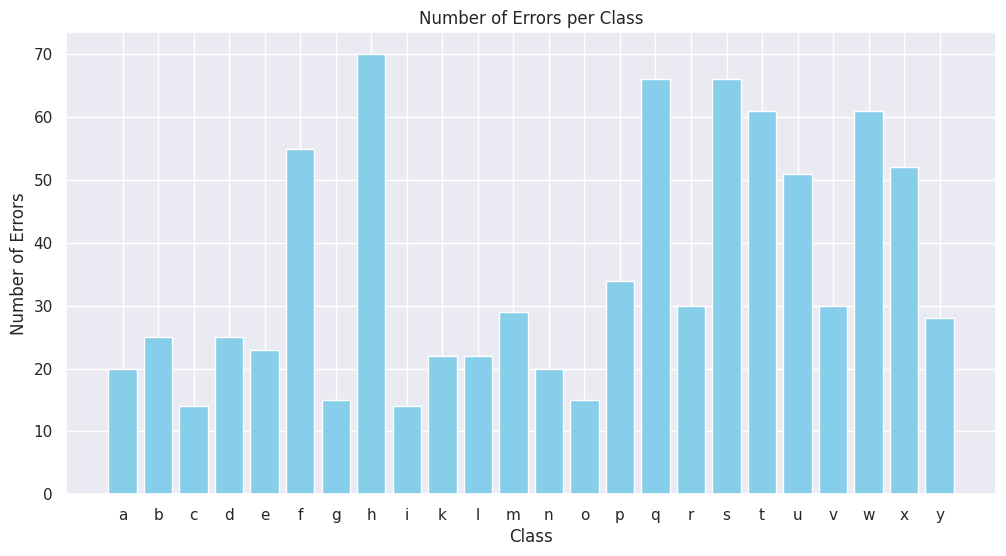

In [107]:
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), errors_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Errors')
plt.title('Number of Errors per Class')
plt.xticks(range(num_classes),classes)

What could be the reasons for the incorrect classification?


In [ ]:
num_classes = len(classes)

# Per ogni classe, trova la classe in cui sbaglia di più
for i in range(num_classes):
    row = cm[i, :].copy()
    row[i] = -1
    most_misclassified_class = np.argmax(row)

    print(f'Class {classes[i]}: {errors_per_class[i]} errors, most often misclassified as class {classes[most_misclassified_class]}')


Class a: 20 errors, most often misclassified as class y
Class b: 25 errors, most often misclassified as class h
Class c: 14 errors, most often misclassified as class l
Class d: 25 errors, most often misclassified as class l
Class e: 23 errors, most often misclassified as class k
Class f: 55 errors, most often misclassified as class x
Class g: 15 errors, most often misclassified as class o
Class h: 70 errors, most often misclassified as class b
Class i: 14 errors, most often misclassified as class r
Class k: 22 errors, most often misclassified as class e
Class l: 22 errors, most often misclassified as class c
Class m: 29 errors, most often misclassified as class a
Class n: 20 errors, most often misclassified as class y
Class o: 15 errors, most often misclassified as class e
Class p: 34 errors, most often misclassified as class x
Class q: 66 errors, most often misclassified as class t
Class r: 30 errors, most often misclassified as class i
Class s: 66 errors, most often misclassified as 

Most of the errors occur on letters with similar hand positions in the original dataset. However, an interesting case is that of the classes p and q, which are different in the original dataset but are confused by the convolutional network (CNNModel).

When a rotation is applied to these two classes, it is likely that they get misclassified. Applying a transformation thus helps address the issue of limited data in the dataset, but it also introduces a new problem.